# Fitting

This notebook is intended to fit the data associated with human CRISPRi activity scores to train a linear regression model to.

The data used is that from the following paper:

[Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation](https://elifesciences.org/articles/19760)

__Authors__: Anthony Hein, Briana Macedo, Manya Kapoor

---

We will attempt to build the following models:
* Fully Connected Neural Network
* Support Vector Machine
* Logisitc Regression
* Elastic Net Linear Regression

_NOTE_ : The paper only creates an Elastic Net Linear Regression model.

---

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [11]:
np.random.seed(0)

In [12]:
features_raw = pd.read_csv('features_binned.csv')
features_raw.head()

,Unnamed: 0,+ve strand,length,longest A,longest C,longest G,longest T,As,Cs,Gs,...,G_comp_0.8,G_comp_0.9,length_21,length_22,length_23,length_24,length_25,length_26,length_27,length_28
0,0,1,24,1,1,2,2,0.142857,0.238095,0.428571,...,False,False,False,False,False,True,False,False,False,False
1,1,1,24,1,4,2,1,0.142857,0.476190,0.333333,...,False,False,False,False,False,True,False,False,False,False
2,2,1,24,1,3,2,1,0.095238,0.380952,0.380952,...,False,False,False,False,False,True,False,False,False,False
3,3,1,24,1,3,2,1,0.238095,0.238095,0.428571,...,False,False,False,False,False,True,False,False,False,False
4,4,1,24,1,3,3,2,0.047619,0.285714,0.523810,...,False,False,False,False,False,True,False,False,False,False


In [18]:
scores_arr = np.array( pd.read_csv('features.csv')['score'])
scores_arr

array([0.01932036, 0.34889211, 0.91240883, ..., 0.215028  , 1.17072619,
       0.57770586])

In [21]:
features_df = features_raw.drop(columns=['Unnamed: 0'])
features_arr = np.array(features_df)

In [22]:
# standardize the data to N(0,1)
scaler = StandardScaler()
scaler.fit(features_arr)
features_arr_std = scaler.transform(features_arr)

In [15]:
# Xs_train = []
# Ys_train = []

# Xs_test = []
# Ys_test = []

# folds = KFold(n_splits=5, shuffle = True)

# for train_index, test_index in folds.split(features_arr_std):
#     Xs_train.append(features_arr_std[train_index])
#     Ys_train.append(features_arr_std[train_index])
    
#     Xs_train.append(features_arr_std[test_index])
#     Ys_train.append(features_arr_std[test_index])

In [23]:
regr = ElasticNetCV(cv=5, random_state=0, max_iter=100000)
regr.fit(features_arr_std, scores_arr)
np.save("coef.npy", regr.coef_)

In [24]:
# R^2
regr.score(features_arr_std, scores_arr)

0.22525562736332017

In [25]:
# R
np.sqrt(regr.score(features_arr_std, scores_arr))

0.474611027435436

In [26]:
preds = regr.predict(features_arr_std)

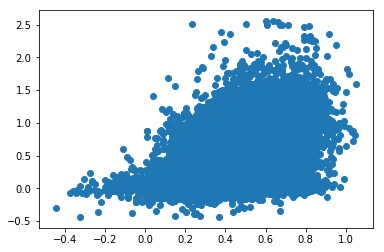

In [27]:
plt.scatter(preds, scores_arr)

In [28]:
mostNeg5 = np.argsort(regr.coef_)[0:5]
mostNeg5

array([475, 491,   5,  96, 443])

In [29]:
features_df.columns[mostNeg5]

Index(['pos_-1_GC', 'pos_-0_GC', 'longest T', 'pos_-4_G', 'pos_-3_GC'], dtype='object')

In [30]:
mostPos5 = np.argsort(regr.coef_)[-5:]
mostPos5

array([486, 106,  12, 497, 498])

In [31]:
features_df.columns[mostPos5]

Index(['pos_-0_CA', 'pos_-1_A', 'AG', 'dist prim 3'', 'dist prim 5''], dtype='object')

In [32]:
preds_bin = preds > 0.75
scores_bin = scores_arr > 0.75

In [33]:
np.sum(abs(preds_bin ^ scores_bin)) / len(preds_bin)

0.24385922033484053

In [34]:
fpr, tpr, thresholds = metrics.roc_curve(scores_bin, preds)

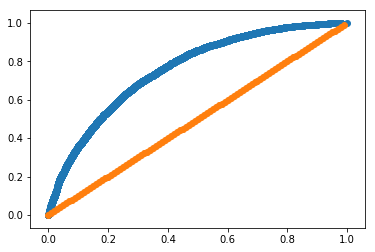

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(fpr, tpr)
ax1.scatter(np.arange(0,1,0.01), np.arange(0,1,0.01))
plt.show()

In [36]:
roc_auc_score(scores_bin, preds)

0.758336170144263

Save coefficients as Numpy array for quick load in other notebooks.

In [240]:
with open("coef_elastic.npy", "wb") as f:
    np.save(f, regr.coef_)